# Travel Times for Asia Railways

This project takes in input edges and border nodes from spreadsheets and constructs travel times in an OD Matrix (origin-destination matrix) format.

## Assumptions:

- edges are bidirectional
- each node in the network is a potential origin and destination

## input data:

- edges have these fields: source, target, link_id, length (km), time (hours)
- nodes have these fields: node_id, name, country, border, gauge_change, if_border_is_an_origin_or_destination

The time cost found in the input data will be converted to a USD per tonnage cost. This is converted using the value of time per ton in USD, which is .102704. This value can be adjusted by modifying the value_of_time_per_ton_in_usd variable.

There are also 2 other ways costs are adjusted in this project:

1. Border costs: There are additional costs for borders. Also some borders have a gauge change. A gauge change is an additional time and monetary cost on top of the standard border crossing time and cost.

2. Access links: The network only has rail links, so the access distance represents the average road distance to reach the rail network's origins and destinations. For now we are adding 50km access links with a speed of 30 km/hr. Therefore 1.67 hours to traverse each access link, with a value of time per ton in USD of .102704, the cost is 0.17117 USD per ton per access link.

border cost assumptions:

- each border crossing has a time of 4 hours and a cost of 20 USD per ton
- each gauge change has a time of 12 hours and a cost of 10 USD per ton

Other project assumptions:

- A border node can be either a potential origin or destination, but not both.


In [204]:
import sys, os, inspect, logging, importlib

import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx

import matplotlib.pyplot as plt

In [205]:
# Get reference to GOSTNets
sys.path.append(r'../../GOSTNets/GOSTNets')
import GOSTnet as gn

In [206]:
scenario_var = "_scenario5"

In [207]:
# Define input data
inputFolder = r'./input_folder{}'.format(scenario_var)
input_edges = pd.read_csv(os.path.join(inputFolder, "edges.csv"))

In [208]:
input_edges

,source,target,link_id,length,cost
0,38,69,1,1304,42.95
1,38,70,2,174,10000.00
2,36,70,3,259,10000.00
3,5,36,4,45,1.95
4,25,5,5,77,3.34
...,...,...,...,...,...
96,36,49,104,22,1.19
97,50,25,105,113,6.11
98,33,79,106,460,10000.00
99,79,80,107,257,10000.00


In [209]:
G = nx.from_pandas_edgelist(input_edges, edge_attr = 'cost')

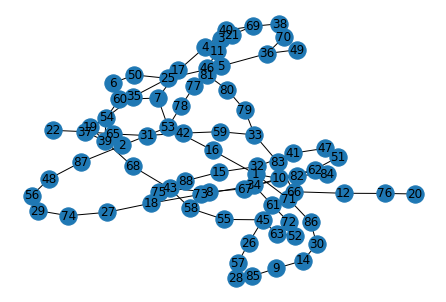

In [210]:
nx.draw(G, with_labels = True)

In [211]:
type(G)

networkx.classes.graph.Graph

## Add border nodes

In [212]:
input_nodes = pd.read_csv(os.path.join(inputFolder, "nodes.csv"))

In [213]:
input_nodes[35:45]

,node_id,name,country,border,gauge_change,if_border_is_an_origin_or_destination,cost
35,39,Khojadavlet/Farab,UBZ,False,False,False,-
36,40,Khorgos,CHI,False,False,False,-
37,41,Kiev,UKR,False,False,False,-
38,42,Mar e Sharif,AFG,False,False,False,-
39,43,Mary,TKM,False,False,False,-
40,45,Mashad,IRA,False,False,False,-
41,46,Mointy,KAZ,False,False,False,-
42,47,Odessa,UKR,True,False,False,23.7
43,48,Orenburg,RUS,False,False,False,-
44,49,Osh,KRG,False,False,False,-


####  Add country names to each node in graph

In [214]:
# loop through input nodes
for index, row in input_nodes.iterrows():
    if row[0]:
        # print(row[0])
        G.nodes[row[0]]['country'] = row[2]

In [215]:
# double-check results
#list(G.nodes(data='country'))

## General methodology
Traversing through a border incurs additional costs. On top of this additional costs are incurred when a gauge change occurs at a border. The way these costs are modeled are by adding 1/2 the costs to each edge adjacent to each border node. This works because each path that traverses a border cost must enter a border node through an edge and exit through a different edge.

### Pre-Processing for border nodes that are also an origin or destination node
(Insert Pic)

There are edge cases when a border node is also either an origin or destination (In this project it is never both). An example to illustrate why this is so:
Imagine a border node is also an origin. Then depending on what side of the border the border node is in then the border cost may not occur at all if the next stop does not cross the border.

#### Phase 1: To handle these edge cases we are adding additional in-between nodes for border nodes that are also an origin or destination node
(insert pic)
Psuedo-code:
```
For each border node that is also an origin or destination node:
    read which country the border node is in
    For each edge adjacent to the border node:
        If the to node is also in the same country as the border node:
            Add an extra node and split the edge
```

In [216]:
# loop through input nodes
for index, row in input_nodes.iterrows():
    # if border node and is either an origin or destination
    if row[5]:
        # country border node is in is row[2]
        print(row[0],row[1],row[2])
        # For each edge adjacent to the border node:
        for entry in list(G.neighbors(row[0])):
            # print('adj node')
            # print(entry)
            # print(G.nodes[entry]['country'])
            # print(row[2])
            # If the to node is also in the same country as the border node:
            if G.nodes[entry]['country'] == row[2]:
                # print("border node and is either an origin or destination is in country: " + str(G.nodes[entry]['country']))
                # add new intermediate node
                G.add_node(str(row[0]) + 'b')
                # add new edge from intermediate node to border node
                G.add_edge(str(row[0]) + 'b',row[0], cost = .000001)
                # add new edge to connect to intermediate node instead of the border node
                G.add_edge(entry, str(row[0]) + 'b', cost = G.edges[entry,row[0]]['cost'] )
                # remove edge
                G.remove_edge(entry,row[0])

10 Baku AZE
18 Brest BEL
68 Turkmenabad TKM


#### Phase 2: Adding 1/2 the costs to each edge adjacent to each border node. 

In [217]:
# border costs
# each border crossing has a time of 4 hours and a cost of $20 per ton
#add_half_border_costs_per_link = (4 * value_of_time_per_ton_in_usd + 20) / 2
# each gauge change has a time of 12 hours and a cost of $10 per ton
#add_half_border_w_gauge_costs_per_link = (12 * value_of_time_per_ton_in_usd + 10) / 2

In [218]:
border_nodes = []
border_nodes_w_gauge_change = []
# loop through input nodes
for index, row in input_nodes.iterrows():
    # if border node
    if row[3]:
        border_nodes.append(row[0])
        #print(row[0],row[1])
        # For each edge adjacent to the border node:
        for entry in list(G.neighbors(row[0])):
            #print('edge')
            #print(entry)
            G.edges[entry,row[0]]['cost'] = G.edges[entry,row[0]]['cost'] + float(row[6])/2

In [219]:
# testing
# len(border_nodes)

In [220]:
# testing
# len(border_nodes_w_gauge_change)

In [221]:
# testing
# G.edges[5,36]

In [222]:
# testing
# for e in G.edges(data = True):
    # For each edge's attribute
    # print(e)

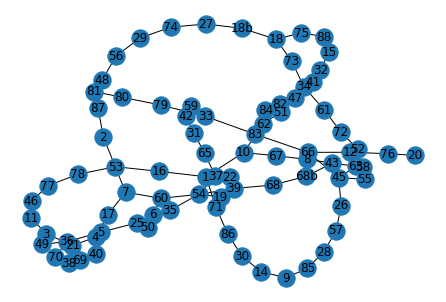

In [223]:
nx.draw(G, with_labels = True)

In [224]:
import importlib
importlib.reload(gn)

<module 'GOSTnet' from '../../GOSTNets/GOSTNets/GOSTnet.py'>

In [225]:
nodes_list = []
for n in G.nodes():
    nodes_list.append(n)

In [226]:
# calculate OD matrix
import time
start = time.time()
OD_matrix = gn.calculate_OD(G, nodes_list, nodes_list, fail_value=-1, weight='cost')
end = time.time()
print(end-start)

0.0840144157409668


In [227]:
OD_matrix

array([[    0.      ,    42.95    , 10011.85    , ..., 30394.190001,
          335.45    ,   194.740001],
       [   42.95    ,     0.      , 10054.8     , ..., 30351.240001,
          292.5     ,   151.790001],
       [10011.85    , 10054.8     ,     0.      , ..., 40350.700001,
        10347.3     , 10151.250001],
       ...,
       [30394.190001, 30351.240001, 40350.700001, ...,     0.      ,
        30434.120001, 30199.45    ],
       [  335.45    ,   292.5     , 10347.3     , ..., 30434.120001,
            0.      ,   308.490001],
       [  194.740001,   151.790001, 10151.250001, ..., 30199.45    ,
          308.490001,     0.      ]])

In [228]:
OD_df = pd.DataFrame(OD_matrix, columns = nodes_list, index = nodes_list)

In [229]:
OD_df

,38,69,70,36,5,25,35,54,37,65,...,47,41,73,22,49,79,80,81,18b,68b
38,0.000000,42.950000,10011.850000,206.785000,168.450000,153.880000,156.760000,152.810000,159.320000,171.520000,...,412.640000,451.480001,398.740001,178.740000,233.130000,10394.190001,20394.190001,30394.190001,335.450000,194.740001
69,42.950000,0.000000,10054.800000,163.835000,125.500000,110.930000,113.810000,109.860000,116.370000,128.570000,...,369.690000,408.530001,355.790001,135.790000,190.180000,10351.240001,20351.240001,30351.240001,292.500000,151.790001
70,10011.850000,10054.800000,0.000000,10037.005000,10075.340000,10089.910000,10105.370000,10109.320000,10115.830000,10128.030000,...,10424.490000,10463.330001,10410.590001,10135.250000,10063.350000,20350.700001,30350.700001,40350.700001,10347.300000,10151.250001
36,206.785000,163.835000,10037.005000,0.000000,38.335000,52.905000,68.365000,72.315000,78.825000,91.025000,...,395.215001,436.565001,383.825001,98.245000,26.345000,10313.695001,20313.695001,30313.695001,320.535000,114.245001
5,168.450000,125.500000,10075.340000,38.335000,0.000000,14.570000,30.030000,33.980000,40.490000,52.690000,...,356.880001,398.230001,345.490001,59.910000,64.680000,10275.360001,20275.360001,30275.360001,282.200000,75.910001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,10394.190001,10351.240001,20350.700001,10313.695001,10275.360001,10260.790001,10245.330001,10241.380001,10237.950001,10250.150001,...,10454.460000,10454.280000,10370.830000,10257.370001,10340.040001,0.000000,10000.000000,20000.000000,10434.120001,10199.450000
80,20394.190001,20351.240001,30350.700001,20313.695001,20275.360001,20260.790001,20245.330001,20241.380001,20237.950001,20250.150001,...,20454.460000,20454.280000,20370.830000,20257.370001,20340.040001,10000.000000,0.000000,10000.000000,20434.120001,20199.450000
81,30394.190001,30351.240001,40350.700001,30313.695001,30275.360001,30260.790001,30245.330001,30241.380001,30237.950001,30250.150001,...,30454.460000,30454.280000,30370.830000,30257.370001,30340.040001,20000.000000,10000.000000,0.000000,30434.120001,30199.450000
18b,335.450000,292.500000,10347.300000,320.535000,282.200000,267.630000,270.510000,266.560000,273.070000,285.270000,...,158.940001,116.030001,63.290001,292.490000,346.880000,10434.120001,20434.120001,30434.120001,0.000000,308.490001


### Phase 3: Add additional access costs to each route

In [230]:
# access costs are 0.17117 USD per ton
OD_df_w_extra_costs = OD_df + 0.17117

In [231]:
OD_df_w_extra_costs.to_csv("asia_railways_output_OD_matrix{}.csv".format(scenario_var))

### Phase 4: print out intermediate links for each route

In [232]:
# OD_df_w_extra_costs.index

In [233]:
# looks up city names from node id
def look_up(x):
    # need to be able to do a lookup in cases of an extra added node such as '68b'
    if type(x) == str:
        print('type is str')
        print(len(x))
        if len(x) == 1:
            print('len is 1')
            return input_nodes.loc[input_nodes['node_id']==x]['name'].iloc[0]
        else:
            print(x[:-1])
            x = int(x[:-1])
            return input_nodes.loc[input_nodes['node_id']==x]['name'].iloc[0]
    else:
        return input_nodes.loc[input_nodes['node_id']==x]['name'].iloc[0]

In [234]:
# test
look_up(45)

'Mashad'

In [235]:
with open("route_stops{}.txt".format(scenario_var), 'a') as the_file:
    # Pandas' iterrows() returns an iterator containing index of each row and the data in each row as a Series
    for idx in OD_df_w_extra_costs.iterrows():
        #print(idx[0])
        row = idx[0]
        #print(idx[1])
        for col,value in idx[1].items():
            #print(col)
            print(row,col)
            the_file.write(str(row)+','+str(col)+'\n')
            shortest_path_list_w_names = []
            for x in nx.bidirectional_shortest_path(G, row, col):
                shortest_path_list_w_names.append(look_up(x)+',')
            print(str(shortest_path_list_w_names))
            the_file.writelines(shortest_path_list_w_names)
            the_file.write('\n')
    

38 38
['Kashgar,']
38 69
['Kashgar,', 'Turpan,']
38 70
['Kashgar,', 'Turugart,']
38 36
['Kashgar,', 'Turugart,', 'Kara Suu,']
38 5
['Kashgar,', 'Turugart,', 'Kara Suu,', 'Andijan,']
38 25
['Kashgar,', 'Turugart,', 'Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,']
38 35
['Kashgar,', 'Turugart,', 'Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,']
38 54
['Kashgar,', 'Turugart,', 'Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,']
38 37
['Kashgar,', 'Turugart,', 'Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Karshi,']
38 65
['Kashgar,', 'Turugart,', 'Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Karshi,', 'Termiz,']
38 31
['Kashgar,', 'Turugart,', 'Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,']
38 39
['Kashgar,', 'Turugart,', 'Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Khojadavlet/Farab,']
38 68
['Kashgar,', 'Turugart,', 

['Kashgar,', 'Turpan,', 'Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Tatvan,', 'Van,']
38 61
['Kashgar,', 'Turpan,', 'Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Tatvan,']
38 8
['Kashgar,', 'Turpan,', 'Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,']
38 67
['Kashgar,', 'Turpan,', 'Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Turkenbashi,']
38 60
['Kashgar,', 'Turpan,', 'Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Tashkent,']
38 19
['Kashgar,', 'Turugart,', 'Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Bukhara,']
38 63
type is str
3
68
['Kashgar,', 'Turugart,', 'Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Tu

['Turpan,', 'Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Vienna,', 'Brest,', 'Warsaw,']
69 88
['Turpan,', 'Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Hamburg,', 'Berlin,', 'Kunowice,']
69 15
['Turpan,', 'Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Hamburg,', 'Berlin,']
69 21
['Turpan,', 'Dostyk,']
69 3
['Turpan,', 'Dostyk,', 'Aktogal,']
69 11
['Turpan,', 'Dostyk,', 'Aktogal,', 'Balkash,']
69 46
['Turpan,', 'Dostyk,', 'Aktogal,', 'Balkash,', 'Mointy,']
69 77
['Turpan,', 'Dostyk,', 'Aktogal,', 'Balkash,', 'Mointy,', 'Zharyk,']
69 78
['Turpan,', 'Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Zhezkagan,']
69 52
['Turpan,', 'Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', '

type is str
3
68
['Turugart,', 'Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Garmsar,']
70 10
['Turugart,', 'Kashgar,', 'Turpan,', 'Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,']
70 62
['Turugart,', 'Kashgar,', 'Turpan,', 'Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,']
70 84
['Turugart,', 'Kashgar,', 'Turpan,', 'Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Rustawi,']
70 82
['Turugart,', 'Kashgar,', 'Turpan,', 'Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,']
70 34
['Turugart,', 'Kashgar,', 'Turpan,', 'Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,']
70 32
['Turugart,'

['Kara Suu,', 'Turugart,', 'Kashgar,', 'Turpan,', 'Khorgos,', 'Almaty,', 'Birlik,']
36 7
['Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,']
36 53
['Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,']
36 16
['Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,']
36 1
['Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,']
36 71
['Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Uren,']
36 86
['Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Uren,', 'No Name,']
36 30
['Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,'

['Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,', 'Sheberghan,', 'Herat,', 'Lashkargah,', 'Bahramcha,']
36 81
['Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,', 'Sheberghan,', 'Herat,', 'Lashkargah,', 'Bahramcha,', 'Gwadar,']
36 18b
type is str
3
18
['Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,', 'Gryazi Lipetsk,', 'Voronezh,', 'Gomel,', 'Brest,']
36 68b
type is str
3
68
['Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,']
5 38
['Andijan,', 'Kara Suu,', 'Turugart,', 'Kashgar,']
5 69
['Andijan,', 'Kara Suu,', 'Turugart,', 'Kashgar,', 'Turpan,']
5 70
['Andijan,', 'Kara Suu,', 'Turugart,']
5 36
['Andijan,', 'Kara Suu,']
5 5
['Andijan,']
5 25
['Andijan,', 'F

['Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Tatvan,']
5 8
type is str
3
68
['Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Ashgabat,']
5 67
type is str
3
68
['Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Ashgabat,', 'Turkenbashi,']
5 60
['Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Tashkent,']
5 19
['Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Bukhara,']
5 63
type is str
3
68
['Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Teheran,']
5 6
['Andijan,', 'Fargona_or_Feghana,', 'Pop,', 'Angren,']
5 50
['Andijan,', 'Fargona_or_Feghana,', 'Pop,']
5 51
['Andijan,', 'Far

['Fargona_or_Feghana,', 'Andijan,', 'Kara Suu,', 'Turugart,', 'Kashgar,', 'Turpan,', 'Dostyk,', 'Aktogal,']
25 11
['Fargona_or_Feghana,', 'Andijan,', 'Kara Suu,', 'Turugart,', 'Kashgar,', 'Turpan,', 'Dostyk,', 'Aktogal,', 'Balkash,']
25 46
['Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Zhezkagan,', 'Zharyk,', 'Mointy,']
25 77
['Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Zhezkagan,', 'Zharyk,']
25 78
['Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Zhezkagan,']
25 52
type is str
3
68
['Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,']
25 72
type is str
3
68
['Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,

['Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,', 'Gryazi Lipetsk,', 'Voronezh,', 'Gomel,']
35 74
['Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,', 'Gryazi Lipetsk,', 'Voronezh,']
35 29
['Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,', 'Gryazi Lipetsk,']
35 56
['Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,']
35 48
['Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,']
35 87
['Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,']
35 2
['Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,']
35 75
['Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Vienna,', 'Brest

['Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,']
54 32
['Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Hamburg,']
54 18
['Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Vienna,', 'Brest,']
54 27
['Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,', 'Gryazi Lipetsk,', 'Voronezh,', 'Gomel,']
54 74
['Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,', 'Gryazi Lipetsk,', 'Voronezh,']
54 29
['Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,', 'Gryazi Lipetsk,']
54 56
['Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,']
54 48
['Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulsk

['Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,']
37 32
['Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Hamburg,']
37 18
['Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Vienna,', 'Brest,']
37 27
['Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,', 'Gryazi Lipetsk,', 'Voronezh,', 'Gomel,']
37 74
['Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,', 'Gryazi Lipetsk,', 'Voronezh,']
37 29
['Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,', 'Gryazi Lipetsk,']
37 56
['Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', '

['Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,']
65 32
['Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Hamburg,']
65 18
['Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Vienna,', 'Brest,']
65 27
['Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,', 'Gryazi Lipetsk,', 'Voronezh,', 'Gomel,']
65 74
['Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,', 'Gryazi Lipetsk,', 'Voronezh,']
65 29
['Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,', 'Gryazi Lipetsk,']
65 56
['Termiz,', 'Karshi,',

['Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,']
31 62
['Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,']
31 84
['Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Rustawi,']
31 82
['Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,']
31 34
['Hairatan,', 'Mar e Sharif,', 'Sheberghan,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,']
31 32
['Hairatan,', 'Mar e Sharif,', 'Sheberghan,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Hamburg,']
31 18
['Hairatan,', 'Mar e Sharif,', 'Sheberghan,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Teheran,

['Khojadavlet/Farab,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,', 'Bereklet,']
39 9
['Khojadavlet/Farab,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,', 'Bereklet,', 'Atrek,']
39 85
type is str
3
68
['Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Garmsar,', 'Sari,', 'Gorgan,', 'Gomishan,']
39 28
type is str
3
68
['Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Garmsar,', 'Sari,', 'Gorgan,']
39 57
type is str
3
68
['Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Garmsar,', 'Sari,']
39 26
type is str
3
68
['Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Garmsar,']
39 10
type is str
3
68
['Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,'

type is str
3
68
['Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Garmsar,', 'Sari,', 'Gorgan,', 'Gomishan,']
68 28
type is str
3
68
['Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Garmsar,', 'Sari,', 'Gorgan,']
68 57
type is str
3
68
['Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Garmsar,', 'Sari,']
68 26
type is str
3
68
['Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Garmsar,']
68 10
type is str
3
68
['Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,']
68 62
type is str
3
68
['Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,']
68 84
type is str
3
68
['Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,', 'Rustawi,']
68 82
type is str
3
68
['Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,', 'Kars,']
68 34
type is s

['Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Garmsar,', 'Sari,', 'Gorgan,', 'Gomishan,']
43 28
['Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Garmsar,', 'Sari,', 'Gorgan,']
43 57
['Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Garmsar,', 'Sari,']
43 26
['Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Garmsar,']
43 10
['Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,']
43 62
['Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,']
43 84
['Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,', 'Rustawi,']
43 82
['Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,', 'Kars,']
43 34
['Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,']
43 32
['Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Hamburg,']
43 18
['Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Vienna,', 'Brest,']
43 27
type is str
3
18
['Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,', 

['Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,']
58 84
['Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,', 'Rustawi,']
58 82
['Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,', 'Kars,']
58 34
['Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,']
58 32
['Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Hamburg,']
58 18
['Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Vienna,', 'Brest,']
58 27
type is str
3
18
['Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Vienna,', 'Brest,', 'Brest,', 'Gomel,']
58 74
type is str
3
18
['Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Vienna,', 'Brest,', 'Brest,', 'Gomel,', 'Voronezh,']
58 29
['Sata

['Saraks,', 'Mashad,', 'Garmsar,', 'Sari,']
55 26
['Saraks,', 'Mashad,', 'Garmsar,']
55 10
['Saraks,', 'Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,']
55 62
['Saraks,', 'Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,']
55 84
['Saraks,', 'Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,', 'Rustawi,']
55 82
['Saraks,', 'Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,', 'Kars,']
55 34
['Saraks,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,']
55 32
['Saraks,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Hamburg,']
55 18
['Saraks,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Vienna,', 'Brest,']
55 27
type is str
3
18
['Saraks,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Vienna,', 'Brest,', 'Brest,', 'Gomel,']
55 74
type is str
3
18
['Saraks,', 'Mashad,', '

['Mashad,', 'Garmsar,', 'Sari,', 'Gorgan,', 'Gomishan,']
45 28
['Mashad,', 'Garmsar,', 'Sari,', 'Gorgan,']
45 57
['Mashad,', 'Garmsar,', 'Sari,']
45 26
['Mashad,', 'Garmsar,']
45 10
['Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,']
45 62
['Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,']
45 84
['Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Kars,', 'Rustawi,']
45 82
['Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Kars,']
45 34
['Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,']
45 32
['Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Hamburg,']
45 18
['Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Vienna,', 'Brest,']
45 27
type is str
3
18
['Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Vienna,', 'Brest,',

['Torbat,', 'Mashad,', 'Garmsar,', 'Sari,', 'Gorgan,', 'Gomishan,', 'Atrek,']
66 85
['Torbat,', 'Mashad,', 'Garmsar,', 'Sari,', 'Gorgan,', 'Gomishan,']
66 28
['Torbat,', 'Mashad,', 'Garmsar,', 'Sari,', 'Gorgan,']
66 57
['Torbat,', 'Mashad,', 'Garmsar,', 'Sari,']
66 26
['Torbat,', 'Mashad,', 'Garmsar,']
66 10
['Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,']
66 62
['Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,']
66 84
['Torbat,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Kars,', 'Rustawi,']
66 82
['Torbat,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Kars,']
66 34
['Torbat,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,']
66 32
['Torbat,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Hamburg,']
66 18
['Torbat,', 'Mashad,', 'Teheran,',

['Barq,', 'Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Birlik,', 'Almaty,']
12 17
type is str
3
68
['Barq,', 'Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Birlik,']
12 7
['Barq,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,']
12 53
['Barq,', 'Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,']
12 16
['Barq,', 'Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Aktau,', 'Beynau,']
12 1
['Barq,', 'Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Aktau,']
12 71
['Barq,', 'Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,',

76 25
type is str
3
68
['Zahedin,', 'Barq,', 'Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,']
76 35
type is str
3
68
['Zahedin,', 'Barq,', 'Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Samarkand,', 'Jizzaz,']
76 54
type is str
3
68
['Zahedin,', 'Barq,', 'Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Samarkand,']
76 37
['Zahedin,', 'Barq,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,']
76 65
['Zahedin,', 'Barq,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,']
76 31
['Zahedin,', 'Barq,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,']
76 39
type is str
3
68
['Zahedin,', 'Barq,', 'Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,

['Zahedin,', 'Barq,', 'Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Samarkand,', 'Tashkent,', 'Angren,', 'Pop,']
76 51
['Zahedin,', 'Barq,', 'Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,', 'Poti,']
76 47
['Zahedin,', 'Barq,', 'Torbat,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Hamburg,', 'Kiev,', 'Odessa,']
76 41
['Zahedin,', 'Barq,', 'Torbat,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Hamburg,', 'Kiev,']
76 73
['Zahedin,', 'Barq,', 'Torbat,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Vienna,']
76 22
['Zahedin,', 'Barq,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Dushanbe,']
76 49
type is str
3
68
['Zahedin,', 'Barq,', 'Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkme

['Chababar,', 'Zahedin,', 'Barq,', 'Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,']
20 87
['Chababar,', 'Zahedin,', 'Barq,', 'Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,']
20 2
['Chababar,', 'Zahedin,', 'Barq,', 'Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Aktobe,']
20 75
['Chababar,', 'Zahedin,', 'Barq,', 'Torbat,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Vienna,', 'Brest,', 'Warsaw,']
20 88
['Chababar,', 'Zahedin,', 'Barq,', 'Torbat,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Hamburg,', 'Berlin,', 'Kunowice,']
20 15
['Chababar,', 'Zahedin,', 'Barq,', 'Torbat,', 'Mashad,', 'Teheran,', 'Razi

['Mar e Sharif,', 'Sheberghan,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Garmsar,', 'Sari,', 'Gorgan,']
42 57
['Mar e Sharif,', 'Sheberghan,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Garmsar,', 'Sari,']
42 26
['Mar e Sharif,', 'Sheberghan,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Garmsar,']
42 10
['Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,']
42 62
['Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,']
42 84
['Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Rustawi,']
42 82
['Mar e Sharif,', 'Sheberghan,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Kars,']
42 34
['Mar e Sharif,', 'Sheberghan,', 'Herat,', 'Shamtiq,', 'Torbat

['Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,']
59 1
['Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,']
59 71
['Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Uren,']
59 86
['Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Uren,', 'No Name,']
59 30
['Sheberghan,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Garmsar,', 'Sari,', 'Gorgan,', 'Gomishan,', 'Atrek,', 'Bereklet,', 'Gyzylgaya,']
59 14
['Sheberghan,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Garmsar,', 'Sari,', 'Gorgan,', 'Gomishan,', 'Atrek,', 'Bereklet,']
59 9
['Sheberghan,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Garmsar,', 'Sari,', 'Gorgan,', 'Gomishan,', 'At

['Herat,', 'Shamtiq,', 'Torbat,', 'Barq,', 'Zahedin,']
33 20
['Herat,', 'Shamtiq,', 'Torbat,', 'Barq,', 'Zahedin,', 'Chababar,']
33 42
['Herat,', 'Sheberghan,', 'Mar e Sharif,']
33 59
['Herat,', 'Sheberghan,']
33 33
['Herat,']
33 83
['Herat,', 'Shamtiq,']
33 40
['Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,']
33 4
['Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Birlik,', 'Almaty,']
33 17
['Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Birlik,']
33 7
['Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,']
33 53
['Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,']
33 16
['Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 

['Shamtiq,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,']
83 25
['Shamtiq,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,']
83 35
['Shamtiq,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Jizzaz,']
83 54
['Shamtiq,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,']
83 37
['Shamtiq,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,']
83 65
['Shamtiq,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,']
83 31
['Shamtiq,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,']
83 39
['Shamtiq,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Khojadavlet/Farab,']
83 68
type is str
3
68
['Shamtiq,', 'Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmen

type is str
3
18
['Shamtiq,', 'Torbat,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Vienna,', 'Brest,', 'Brest,']
83 68b
type is str
3
68
['Shamtiq,', 'Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmenabad,']
40 38
['Khorgos,', 'Turpan,', 'Kashgar,']
40 69
['Khorgos,', 'Turpan,']
40 70
['Khorgos,', 'Turpan,', 'Kashgar,', 'Turugart,']
40 36
['Khorgos,', 'Turpan,', 'Kashgar,', 'Turugart,', 'Kara Suu,']
40 5
['Khorgos,', 'Turpan,', 'Kashgar,', 'Turugart,', 'Kara Suu,', 'Andijan,']
40 25
['Khorgos,', 'Turpan,', 'Kashgar,', 'Turugart,', 'Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,']
40 35
['Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,']
40 54
['Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Tashkent,', 'Samarkand,']
40 37
['Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,']
40 65
['Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,']
40 31
[

['Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Poti,']
40 47
['Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Poti,', 'Odessa,']
40 41
['Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Poti,', 'Odessa,', 'Kiev,']
40 73
['Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Vienna,']
40 22
['Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Dushanbe,']
40 49
['Khorgos,', 'Turpan,', 'Kashgar,', 'Turugart,', 'Kara Suu,', 'Osh,']
40 79
['Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,', 'Sheberghan,', 'Herat,', 'Lashkargah,']
40 80
['Khorgos,', 'Almaty,', 'Birlik,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Shari

['Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Turkenbashi,']
4 60
['Almaty,', 'Birlik,', 'Arys,', 'Tashkent,']
4 19
['Almaty,', 'Birlik,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Bukhara,']
4 63
type is str
3
68
['Almaty,', 'Birlik,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Teheran,']
4 6
['Almaty,', 'Birlik,', 'Arys,', 'Tashkent,', 'Angren,']
4 50
['Almaty,', 'Birlik,', 'Arys,', 'Tashkent,', 'Angren,', 'Pop,']
4 51
['Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Poti,']
4 47
['Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Poti,', 'Odessa,']
4 41
['Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Poti,', 'Odessa,', 'Kiev,']
4 73
['Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'ista

type is str
3
68
['Birlik,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Teheran,']
17 6
['Birlik,', 'Arys,', 'Tashkent,', 'Angren,']
17 50
['Birlik,', 'Arys,', 'Tashkent,', 'Angren,', 'Pop,']
17 51
['Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Poti,']
17 47
['Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Poti,', 'Odessa,']
17 41
['Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Poti,', 'Odessa,', 'Kiev,']
17 73
['Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Vienna,']
17 22
['Birlik,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Dushanbe,']
17 49
['Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,', 'Kashgar,', 'Turugart,', 'Kara Suu,', 'Osh,']
17 79
['Birlik,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar

['Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,', 'Kara Suu,', 'Osh,']
7 79
['Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,', 'Sheberghan,', 'Herat,', 'Lashkargah,']
7 80
['Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,', 'Sheberghan,', 'Herat,', 'Lashkargah,', 'Bahramcha,']
7 81
['Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,', 'Sheberghan,', 'Herat,', 'Lashkargah,', 'Bahramcha,', 'Gwadar,']
7 18b
type is str
3
18
['Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,', 'Gryazi Lipetsk,', 'Voronezh,', 'Gomel,', 'Brest,']
7 68b
type is str
3
68
['Arys,', 'Tashkent,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,']
53 38
['Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,', 'Kashgar,']
53 69
['Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,']
53 70
['Saksaulskaya,', 

['Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,', 'Kashgar,']
16 69
['Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,']
16 70
['Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,', 'Kashgar,', 'Turugart,']
16 36
['Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,', 'Kara Suu,']
16 5
['Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,']
16 25
['Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,']
16 35
['Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,']
16 54
['Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,']
16 37
['Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,']
16 65
['Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,']
16 31
['Beynau,', 'Saks

['Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,']
1 39
['Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Khojadavlet/Farab,']
1 68
type is str
3
68
['Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,']
1 43
['Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,']
1 58
['Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,']
1 55
['Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,']
1 45
['Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,']
1 66
['Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,']
1 12
['Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,', 'Barq,']
1 76
['Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,'

['Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,', 'Sheberghan,']
71 33
['Uren,', 'Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,']
71 83
['Uren,', 'Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,', 'Shamtiq,']
71 40
['Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,']
71 4
['Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,']
71 17
['Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,']
71 7
['Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,']
71 53
['Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,']
71 16
['Uren,', 'Aktau,', 'Beynau,']
71 1
['Uren,', 'Aktau,']
71 71
['Uren,']
71 86
['Uren,', 'No Name,']
71 30
['Uren,', 'No Name,', 'Gyzylgaya,']
71 14
['Uren,', 'No Name,', 'Gyzylgaya,', 'Bereklet,

['No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,']
86 17
['No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,']
86 7
['No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,']
86 53
['No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,']
86 16
['No Name,', 'Uren,', 'Aktau,', 'Beynau,']
86 1
['No Name,', 'Uren,', 'Aktau,']
86 71
['No Name,', 'Uren,']
86 86
['No Name,']
86 30
['No Name,', 'Gyzylgaya,']
86 14
['No Name,', 'Gyzylgaya,', 'Bereklet,']
86 9
['No Name,', 'Gyzylgaya,', 'Bereklet,', 'Atrek,']
86 85
['No Name,', 'Gyzylgaya,', 'Bereklet,', 'Atrek,', 'Gomishan,']
86 28
['No Name,', 'Gyzylgaya,', 'Bereklet,', 'Atrek,', 'Gomishan,', 'Gorgan,']
86 57
['No Name,', 'Gyzylgaya,', 'Bereklet,', 'Atrek,', 'Gomishan,', 'Gorgan,', 'Sari,']
86 26
['No Name,', 'Gyzylgaya,', 'Bereklet,', 'Atrek,', 'Gomishan,', 'Gorgan,', 'Sari,', 'Garmsar,']
86 10
['No Name,', 'Uren,', 'Aktau,', 'Baku,']
86 62
['No Name,', 'Uren,', 'A

['Gyzylgaya,', 'Bereklet,', 'Atrek,', 'Gomishan,', 'Gorgan,', 'Sari,', 'Garmsar,', 'Mashad,', 'Torbat,', 'Barq,', 'Zahedin,']
30 20
['Gyzylgaya,', 'Bereklet,', 'Atrek,', 'Gomishan,', 'Gorgan,', 'Sari,', 'Garmsar,', 'Mashad,', 'Torbat,', 'Barq,', 'Zahedin,', 'Chababar,']
30 42
['Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,']
30 59
['Gyzylgaya,', 'Bereklet,', 'Atrek,', 'Gomishan,', 'Gorgan,', 'Sari,', 'Garmsar,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Sheberghan,']
30 33
['Gyzylgaya,', 'Bereklet,', 'Atrek,', 'Gomishan,', 'Gorgan,', 'Sari,', 'Garmsar,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,']
30 83
['Gyzylgaya,', 'Bereklet,', 'Atrek,', 'Gomishan,', 'Gorgan,', 'Sari,', 'Garmsar,', 'Mashad,', 'Torbat,', 'Shamtiq,']
30 40
['Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,']
30 4
['Gyzylgaya,', 'No Name,', 'U

['Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,']
14 65
['Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,']
14 31
['Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,']
14 39
['Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Khojadavlet/Farab,']
14 68
type is str
3
68
['Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,']
14 43
['Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,']
14 58
['Bereklet,', 'Atrek,', 'Gomishan,', 'Gorgan,', 'Sari,', 'Garmsar,', 'Mashad,', 'Saraks,', 'Satay Junct,']
14 55
['Berekl

type is str
3
18
['Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Vienna,', 'Brest,', 'Brest,']
14 68b
type is str
3
68
['Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Turkmenabad,']
9 38
['Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,', 'Kashgar,']
9 69
['Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,']
9 70
['Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,', 'Kashgar,', 'Turugart,']
9 36
['Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,', 'Kara 

9 67
['Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Baku,', 'Turkenbashi,']
9 60
['Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,']
9 19
['Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Bukhara,']
9 63
['Atrek,', 'Gomishan,', 'Gorgan,', 'Sari,', 'Garmsar,', 'Mashad,', 'Teheran,']
9 6
['Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Angren,']
9 50
['Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Angren,', 'Pop,']
9 51
['Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Poti,']
9 47
['Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Poti,', 'Odessa,']
9 41
['Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No 

['Gomishan,', 'Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,']
85 2
['Gomishan,', 'Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Aktobe,']
85 75
['Gomishan,', 'Gorgan,', 'Sari,', 'Garmsar,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Vienna,', 'Brest,', 'Warsaw,']
85 88
['Gomishan,', 'Gorgan,', 'Sari,', 'Garmsar,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Hamburg,', 'Berlin,', 'Kunowice,']
85 15
['Gomishan,', 'Gorgan,', 'Sari,', 'Garmsar,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Hamburg,', 'Berlin,']
85 21
['Gomishan,', 'Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Dostyk,']
85 3
['Gomishan,', 'Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau

['Gorgan,', 'Gomishan,', 'Atrek,']
28 85
['Gorgan,', 'Gomishan,']
28 28
['Gorgan,']
28 57
['Gorgan,', 'Sari,']
28 26
['Gorgan,', 'Sari,', 'Garmsar,']
28 10
['Gorgan,', 'Gomishan,', 'Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Baku,']
28 62
['Gorgan,', 'Gomishan,', 'Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Baku,', 'Tbilisi,']
28 84
['Gorgan,', 'Gomishan,', 'Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Rustawi,']
28 82
['Gorgan,', 'Sari,', 'Garmsar,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Kars,']
28 34
['Gorgan,', 'Sari,', 'Garmsar,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,']
28 32
['Gorgan,', 'Sari,', 'Garmsar,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Hamburg,']
28 18
['Gorgan,', 'Sari,', 'Garmsar,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul o

['Sari,', 'Garmsar,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,']
57 83
['Sari,', 'Garmsar,', 'Mashad,', 'Torbat,', 'Shamtiq,']
57 40
['Sari,', 'Gorgan,', 'Gomishan,', 'Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,']
57 4
['Sari,', 'Gorgan,', 'Gomishan,', 'Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,']
57 17
['Sari,', 'Gorgan,', 'Gomishan,', 'Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,']
57 7
['Sari,', 'Gorgan,', 'Gomishan,', 'Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,']
57 53
['Sari,', 'Gorgan,', 'Gomishan,', 'Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'Uren,', 'Aktau,', 'Beynau,', 'Saksaulskaya,']
57 16
['Sari,', 'Gorgan,', 'Gomishan,', 'Atrek,', 'Bereklet,', 'Gyzylgaya,', 'No Name,', 'U

['Garmsar,', 'Mashad,']
26 66
['Garmsar,', 'Mashad,', 'Torbat,']
26 12
['Garmsar,', 'Mashad,', 'Torbat,', 'Barq,']
26 76
['Garmsar,', 'Mashad,', 'Torbat,', 'Barq,', 'Zahedin,']
26 20
['Garmsar,', 'Mashad,', 'Torbat,', 'Barq,', 'Zahedin,', 'Chababar,']
26 42
['Garmsar,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,']
26 59
['Garmsar,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Sheberghan,']
26 33
['Garmsar,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,']
26 83
['Garmsar,', 'Mashad,', 'Torbat,', 'Shamtiq,']
26 40
type is str
3
68
['Garmsar,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,']
26 4
type is str
3
68
['Garmsar,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Birlik,', 'Almaty,']
26 17
type is str
3
68
['Garmsar,', 'Mashad,', 'Saraks,', 

['Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,']
10 65
['Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,']
10 31
['Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,']
10 39
type is str
3
68
['Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,']
10 68
type is str
3
68
['Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,']
10 43
['Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,']
10 58
['Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,']
10 55
['Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,']
10 45
['Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,']
10 66
['Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,']
10 12
['Baku,', 'Turkenbashi,', 'Ashgaba

['Tbilisi,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,', 'Barq,', 'Zahedin,']
62 20
['Tbilisi,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,', 'Barq,', 'Zahedin,', 'Chababar,']
62 42
['Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,']
62 59
['Tbilisi,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Sheberghan,']
62 33
['Tbilisi,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,']
62 83
['Tbilisi,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,', 'Shamtiq,']
62 40
['Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,']
62 4
['Tbilisi,', 'Baku,', 'Aktau,', 'Beyn

['Rustawi,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,']
84 4
['Rustawi,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,']
84 17
['Rustawi,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,']
84 7
['Rustawi,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,']
84 53
['Rustawi,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,']
84 16
['Rustawi,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,']
84 1
['Rustawi,', 'Tbilisi,', 'Baku,', 'Aktau,']
84 71
['Rustawi,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Uren,']
84 86
['Rustawi,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Uren,', 'No Name,']
84 30
['Rustawi,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,']
84 14
['Rustawi,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,', 'Bereklet,']
84 9
['Rustawi,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,', 'Berekle

['Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,']
82 17
['Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,']
82 7
['Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,']
82 53
['Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,']
82 16
['Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,']
82 1
['Kars,', 'Tbilisi,', 'Baku,', 'Aktau,']
82 71
['Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Uren,']
82 86
['Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Uren,', 'No Name,']
82 30
['Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,']
82 14
['Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,', 'Bereklet,']
82 9
['Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,', 'Bereklet,', 'Atrek,']
82 85
['Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,', 'Bereklet,', 'Atrek,', 'Gomishan,']
82 28
['Kars,', 'ist

['istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,']
34 4
['istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,']
34 17
['istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,']
34 7
['istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,']
34 53
['istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,']
34 16
['istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,']
34 1
['istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,']
34 71
['istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Uren,']
34 86
['istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Uren,', 'No Name,']
34 30
['istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,']


['Hamburg,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,']
32 83
['Hamburg,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,']
32 40
['Hamburg,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,']
32 4
['Hamburg,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,']
32 17
['Hamburg,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,']
32 7
['Hamburg,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,']
32 53
['Hamburg,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,']
32 16
['Hamburg,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,']
32 1
['Hambu

['Brest,', 'Vienna,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,']
18 12
['Brest,', 'Vienna,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Barq,']
18 76
['Brest,', 'Vienna,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Barq,', 'Zahedin,']
18 20
['Brest,', 'Vienna,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Barq,', 'Zahedin,', 'Chababar,']
18 42
['Brest,', 'Vienna,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,']
18 59
['Brest,', 'Vienna,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Sheberghan,']
18 33
['Brest,', 'Vienna,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,',

['Gomel,', 'Voronezh,', 'Gryazi Lipetsk,', 'Saratov,', 'Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,']
27 65
['Gomel,', 'Voronezh,', 'Gryazi Lipetsk,', 'Saratov,', 'Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,']
27 31
['Gomel,', 'Voronezh,', 'Gryazi Lipetsk,', 'Saratov,', 'Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,']
27 39
['Gomel,', 'Voronezh,', 'Gryazi Lipetsk,', 'Saratov,', 'Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Khojadavlet/Farab,']
27 68
['Gomel,', 'Voronezh,', 'Gryazi Lipetsk,', 'Saratov,', 'Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,']
27 43
type is str
3
18
['Gomel,', 'Brest,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Turkenbashi,', 

['Gomel,', 'Voronezh,', 'Gryazi Lipetsk,', 'Saratov,', 'Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,', 'Kara Suu,', 'Osh,']
27 79
type is str
3
18
['Gomel,', 'Brest,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Lashkargah,']
27 80
type is str
3
18
['Gomel,', 'Brest,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Lashkargah,', 'Bahramcha,']
27 81
type is str
3
18
['Gomel,', 'Brest,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Lashkargah,', 'Bahramcha,', 'Gwadar,']
27 18b
type is str
3
18
['Gomel,', 'Brest,']
27 68b
type is str
3
18
type is str
3
68
['Gomel,', 'Brest,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,'

['Voronezh,', 'Gomel,', 'Brest,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Tatvan,', 'Van,']
74 61
type is str
3
18
['Voronezh,', 'Gomel,', 'Brest,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Tatvan,']
74 8
type is str
3
18
['Voronezh,', 'Gomel,', 'Brest,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Turkenbashi,', 'Ashgabat,']
74 67
type is str
3
18
['Voronezh,', 'Gomel,', 'Brest,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Turkenbashi,']
74 60
['Voronezh,', 'Gryazi Lipetsk,', 'Saratov,', 'Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Arys,', 'Tashkent,']
74 19
['Voronezh,', 'Gryazi Lipetsk,', 'Saratov,', 'Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Bukhara,']
74 63
type is str
3
18
['Voronezh,', 'Gomel,', 'Brest,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,']
74 6
['Voronezh,', 'Gryazi Lipetsk,', 'Saratov,', 'Orenburg,', 'Y

['Gryazi Lipetsk,', 'Voronezh,', 'Gomel,', 'Brest,', 'Brest,', 'Vienna,', 'istanbul or Edime,']
29 32
type is str
3
18
['Gryazi Lipetsk,', 'Voronezh,', 'Gomel,', 'Brest,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Hamburg,']
29 18
type is str
3
18
['Gryazi Lipetsk,', 'Voronezh,', 'Gomel,', 'Brest,', 'Brest,']
29 27
['Gryazi Lipetsk,', 'Voronezh,', 'Gomel,']
29 74
['Gryazi Lipetsk,', 'Voronezh,']
29 29
['Gryazi Lipetsk,']
29 56
['Gryazi Lipetsk,', 'Saratov,']
29 48
['Gryazi Lipetsk,', 'Saratov,', 'Orenburg,']
29 87
['Gryazi Lipetsk,', 'Saratov,', 'Orenburg,', 'Yaysan,']
29 2
['Gryazi Lipetsk,', 'Saratov,', 'Orenburg,', 'Yaysan,', 'Aktobe,']
29 75
type is str
3
18
['Gryazi Lipetsk,', 'Voronezh,', 'Gomel,', 'Brest,', 'Brest,', 'Warsaw,']
29 88
type is str
3
18
['Gryazi Lipetsk,', 'Voronezh,', 'Gomel,', 'Brest,', 'Brest,', 'Warsaw,', 'Kunowice,']
29 15
type is str
3
18
['Gryazi Lipetsk,', 'Voronezh,', 'Gomel,', 'Brest,', 'Brest,', 'Warsaw,', 'Kunowice,', 'Berlin,']
29 21
['Gryazi Lipetsk

['Saratov,', 'Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,', 'Bereklet,']
56 9
['Saratov,', 'Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,', 'Bereklet,', 'Atrek,']
56 85
['Saratov,', 'Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,', 'Bereklet,', 'Atrek,', 'Gomishan,']
56 28
['Saratov,', 'Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,', 'Bereklet,', 'Atrek,', 'Gomishan,', 'Gorgan,']
56 57
['Saratov,', 'Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,', 'Bereklet,', 'Atrek,', 'Gomishan,', 'Gorgan,', 'Sari,']
56 26
type is str
3
18
['Saratov,', 'Gryazi Lipetsk,', 'Voronezh,', 'Gomel,', 'Brest,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Garmsa

['Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,']
48 17
['Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Arys,', 'Birlik,']
48 7
['Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Arys,']
48 53
['Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,']
48 16
['Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Beynau,']
48 1
['Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Beynau,', 'Aktau,']
48 71
['Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Uren,']
48 86
['Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Uren,', 'No Name,']
48 30
['Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,']
48 14
['Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,', 'Bereklet,']
48 9
['Orenburg,', 'Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,', 'Bereklet,', 'A

['Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,', 'Barq,', 'Zahedin,']
87 20
['Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,', 'Barq,', 'Zahedin,', 'Chababar,']
87 42
['Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,']
87 59
['Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,', 'Sheberghan,']
87 33
['Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,', 'Sheberghan,', 'Herat,']
87 83
['Yaysan,', 'Aktobe,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,', 'Sheberghan,', 'Herat,', 'Shamtiq,']
87 40
['Yays

['Aktobe,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,']
2 66
['Aktobe,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,']
2 12
['Aktobe,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,', 'Barq,']
2 76
['Aktobe,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,', 'Barq,', 'Zahedin,']
2 20
['Aktobe,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,', 'Barq,', 'Zahedin,', 'Chababar,']
2 42
['Aktobe,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,']
2 59
['Aktobe,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Kars

['Warsaw,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,']
75 43
['Warsaw,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,']
75 58
['Warsaw,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,']
75 55
['Warsaw,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Saraks,']
75 45
['Warsaw,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,']
75 66
['Warsaw,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,']
75 12
['Warsaw,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Barq,']
75 76
['Warsaw,', 'Brest,', 'Vienna,', 'istanbul 

['Kunowice,', 'Berlin,', 'Hamburg,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,', 'Kashgar,', 'Turugart,']
88 36
['Kunowice,', 'Berlin,', 'Hamburg,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,', 'Kara Suu,']
88 5
['Kunowice,', 'Berlin,', 'Hamburg,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,']
88 25
['Kunowice,', 'Berlin,', 'Hamburg,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,']
88 35
['Kunowice,', 'Berlin,', 'Hamburg,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashke

['Kunowice,', 'Berlin,', 'Hamburg,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Angren,']
88 50
['Kunowice,', 'Berlin,', 'Hamburg,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Angren,', 'Pop,']
88 51
['Kunowice,', 'Berlin,', 'Hamburg,', 'Kiev,', 'Odessa,', 'Poti,']
88 47
['Kunowice,', 'Berlin,', 'Hamburg,', 'Kiev,', 'Odessa,']
88 41
['Kunowice,', 'Berlin,', 'Hamburg,', 'Kiev,']
88 73
['Kunowice,', 'Warsaw,', 'Brest,', 'Vienna,']
88 22
['Kunowice,', 'Berlin,', 'Hamburg,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Dushanbe,']
88 49
['Kunowice,', 'Berlin,', 'Hamburg,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,', 'Kara Suu,', 'Osh,'

['Berlin,', 'Hamburg,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Dostyk,', 'Aktogal,']
15 11
['Berlin,', 'Hamburg,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Zhezkagan,', 'Zharyk,', 'Mointy,', 'Balkash,']
15 46
['Berlin,', 'Hamburg,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Zhezkagan,', 'Zharyk,', 'Mointy,']
15 77
['Berlin,', 'Hamburg,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Zhezkagan,', 'Zharyk,']
15 78
['Berlin,', 'Hamburg,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Zhezkagan,']
15 52
['Berlin,', 'Hamburg,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,']
15 72
['Berlin,', 'Hamburg,', 'istanbul or Edime,', 'Tatvan,', 'Van,']
15 61
['Berlin,', 'Hamburg,', 'istanbul or Edime,', 'Tatvan,']
15 8
['

['Dostyk,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,', 'Gryazi Lipetsk,']
21 56
['Dostyk,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,']
21 48
['Dostyk,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,']
21 87
['Dostyk,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,']
21 2
['Dostyk,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Aktobe,']
21 75
['Dostyk,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Vienna,', 'Brest,', 'Warsaw,']
21 88
['Dostyk,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Hamburg,', 'Berlin,', 'Kunowice,']
21 15
['Dostyk,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Hamburg,',

['Aktogal,', 'Dostyk,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,', 'Bereklet,', 'Atrek,', 'Gomishan,', 'Gorgan,', 'Sari,']
3 26
type is str
3
68
['Aktogal,', 'Dostyk,', 'Almaty,', 'Birlik,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Garmsar,']
3 10
['Aktogal,', 'Dostyk,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,']
3 62
['Aktogal,', 'Dostyk,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,']
3 84
['Aktogal,', 'Dostyk,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Rustawi,']
3 82
['Aktogal,', 'Dostyk,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Kars,']
3 34
['Aktogal,', 'Dostyk,', 'Almaty,', 'Birlik,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilis

['Balkash,', 'Aktogal,', 'Dostyk,', 'Almaty,', 'Birlik,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,', 'Sheberghan,']
11 33
['Balkash,', 'Aktogal,', 'Dostyk,', 'Almaty,', 'Birlik,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,', 'Sheberghan,', 'Herat,']
11 83
['Balkash,', 'Aktogal,', 'Dostyk,', 'Almaty,', 'Birlik,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,', 'Sheberghan,', 'Herat,', 'Shamtiq,']
11 40
['Balkash,', 'Aktogal,', 'Dostyk,', 'Turpan,', 'Khorgos,']
11 4
['Balkash,', 'Aktogal,', 'Dostyk,', 'Almaty,']
11 17
['Balkash,', 'Aktogal,', 'Dostyk,', 'Almaty,', 'Birlik,']
11 7
['Balkash,', 'Aktogal,', 'Dostyk,', 'Almaty,', 'Birlik,', 'Arys,']
11 53
['Balkash,', 'Mointy,', 'Zharyk,', 'Zhezkagan,', 'Saksaulskaya,']
11 16
['Balkash,', 'Mointy,', 'Zharyk,', 'Zhezkagan,', 'Saksaulskaya,', 'Beynau,']
11 1
['Balkash,', 'Mointy,', 'Zharyk,', 'Zhezkagan,', 'Saksaulska

['Mointy,', 'Zharyk,', 'Zhezkagan,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,']
46 58
['Mointy,', 'Zharyk,', 'Zhezkagan,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,']
46 55
['Mointy,', 'Zharyk,', 'Zhezkagan,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,']
46 45
['Mointy,', 'Zharyk,', 'Zhezkagan,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,']
46 66
['Mointy,', 'Zharyk,', 'Zhezkagan,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,']
46 12
['Mointy,', 'Zharyk,', 'Zhezkagan,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,', 'Barq,']
46 76
['Mointy,', 'Zharyk,', 'Zhezkagan,', 'Saksau

type is str
3
68
['Mointy,', 'Zharyk,', 'Zhezkagan,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,']
77 38
['Zharyk,', 'Mointy,', 'Balkash,', 'Aktogal,', 'Dostyk,', 'Turpan,', 'Kashgar,']
77 69
['Zharyk,', 'Mointy,', 'Balkash,', 'Aktogal,', 'Dostyk,', 'Turpan,']
77 70
['Zharyk,', 'Mointy,', 'Balkash,', 'Aktogal,', 'Dostyk,', 'Turpan,', 'Kashgar,', 'Turugart,']
77 36
['Zharyk,', 'Mointy,', 'Balkash,', 'Aktogal,', 'Dostyk,', 'Turpan,', 'Kashgar,', 'Turugart,', 'Kara Suu,']
77 5
['Zharyk,', 'Zhezkagan,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,']
77 25
['Zharyk,', 'Zhezkagan,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,']
77 35
['Zharyk,', 'Zhezkagan,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,']
77 54
['Zharyk,', 'Zhezkagan,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,']
77 37
['Zharyk,', 'Zhezkagan,', 'S

['Zharyk,', 'Zhezkagan,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,', 'Sheberghan,', 'Herat,', 'Lashkargah,', 'Bahramcha,', 'Gwadar,']
77 18b
type is str
3
18
['Zharyk,', 'Zhezkagan,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,', 'Gryazi Lipetsk,', 'Voronezh,', 'Gomel,', 'Brest,']
77 68b
type is str
3
68
['Zharyk,', 'Zhezkagan,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,']
78 38
['Zhezkagan,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,', 'Kashgar,']
78 69
['Zhezkagan,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,']
78 70
['Zhezkagan,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,', 'Kashgar,', 'Turugart,']
78 36
['Zhezkagan,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,', 'Kara Suu,']
78 5
['Zhezkagan,', 'Saksaulskaya,'

type is str
3
68
['Zhezkagan,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,']
52 38
['Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,', 'Kashgar,']
52 69
['Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,']
52 70
type is str
3
68
['Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,', 'Kara Suu,', 'Turugart,']
52 36
type is str
3
68
['Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,', 'Kara Suu,']
52 5
typ

['Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Lashkargah,', 'Bahramcha,']
52 81
['Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Lashkargah,', 'Bahramcha,', 'Gwadar,']
52 18b
type is str
3
18
['Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Vienna,', 'Brest,', 'Brest,']
52 68b
type is str
3
68
['Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmenabad,']
72 38
['Van,', 'Tatvan,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,', 'Kashgar,']
72 69
['Van,', 'Tatvan,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,']
72 70
['Van,', 'Tatvan,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,', 'Kashgar,', 'Turugart,']

type is str
3
68
['Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Karshi,', 'Dushanbe,']
72 49
type is str
3
68
['Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,', 'Kara Suu,', 'Osh,']
72 79
['Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Lashkargah,']
72 80
['Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Lashkargah,', 'Bahramcha,']
72 81
['Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Lashkargah,', 'Bahramcha,', 'Gwadar,']
72 18b
type is str
3
18
['Van,', 'Tatvan,', 'istanbul or Edime,', 'Vienna,', 'Brest,', 'Brest,']
72 68b
type is str
3
68
['Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmenabad,']
61 38
[

['Tatvan,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Poti,']
61 47
['Tatvan,', 'istanbul or Edime,', 'Hamburg,', 'Kiev,', 'Odessa,']
61 41
['Tatvan,', 'istanbul or Edime,', 'Hamburg,', 'Kiev,']
61 73
['Tatvan,', 'istanbul or Edime,', 'Vienna,']
61 22
type is str
3
68
['Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Karshi,', 'Dushanbe,']
61 49
['Tatvan,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,', 'Kara Suu,', 'Osh,']
61 79
['Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Lashkargah,']
61 80
['Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Lashkargah,', 'Bahramcha,']
61 81
['Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'La

['Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Lashkargah,', 'Bahramcha,', 'Gwadar,']
8 18b
type is str
3
18
['Ashgabat,', 'Turkenbashi,', 'Baku,', 'Tbilisi,', 'Kars,', 'istanbul or Edime,', 'Vienna,', 'Brest,', 'Brest,']
8 68b
type is str
3
68
['Ashgabat,', 'Mary,', 'Turkmenabad,']
67 38
['Turkenbashi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,', 'Kashgar,']
67 69
['Turkenbashi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,']
67 70
['Turkenbashi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,', 'Kashgar,', 'Turugart,']
67 36
type is str
3
68
['Turkenbashi,', 'Ashgabat,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,', 'Kara Suu,']
67 5
type is str
3
68
['Turkenbashi,', 'Ashgabat,', 'Mary,', 'Turkmena

['Tashkent,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,']
60 55
type is str
3
68
['Tashkent,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,']
60 45
type is str
3
68
['Tashkent,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,']
60 66
type is str
3
68
['Tashkent,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,']
60 12
type is str
3
68
['Tashkent,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,', 'Barq,']
60 76
type is str
3
68
['Tashkent,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,', 'Barq,', 'Zahedin,']
60 20
type is str
3
68
['Tashkent,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmen

['Bukhara,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,', 'Sheberghan,', 'Herat,', 'Shamtiq,']
19 40
['Bukhara,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,']
19 4
['Bukhara,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Birlik,', 'Almaty,']
19 17
['Bukhara,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Birlik,']
19 7
['Bukhara,', 'Samarkand,', 'Tashkent,', 'Arys,']
19 53
['Bukhara,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,']
19 16
['Bukhara,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,']
19 1
['Bukhara,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,']
19 71
['Bukhara,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Uren,']
19 86
['Bukhara,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Uren,', 'No Name,']
19 30
['Bukhara,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,']
19 14
['

['Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,']
63 59
['Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Sheberghan,']
63 33
['Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,']
63 83
['Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,']
63 40
type is str
3
68
['Teheran,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,']
63 4
type is str
3
68
['Teheran,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Birlik,', 'Almaty,']
63 17
type is str
3
68
['Teheran,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Birlik,']
63 7
type is str
3
68
['Teheran,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab

type is str
3
68
['Angren,', 'Tashkent,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,', 'Barq,', 'Zahedin,', 'Chababar,']
6 42
['Angren,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,']
6 59
['Angren,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,', 'Sheberghan,']
6 33
['Angren,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,', 'Sheberghan,', 'Herat,']
6 83
['Angren,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,', 'Sheberghan,', 'Herat,', 'Shamtiq,']
6 40
['Angren,', 'Tashkent,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,']
6 4
['Angren,', 'Tashkent,', 'Arys,', 'Birlik,', 'Almaty,']
6 17
['Angren,', 'Tashkent,', 'Arys,', 'Birlik,']
6 7
['Angren,', 'Tashkent,', 'Arys,']
6 53
['Angren,', 'Tashkent,', 'Arys,', 'Saksaulskaya,']
6 16
['Angren,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Bey

['Pop,', 'Angren,', 'Tashkent,', 'Samarkand,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Torbat,', 'Barq,', 'Zahedin,', 'Chababar,']
50 42
['Pop,', 'Angren,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,']
50 59
['Pop,', 'Angren,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,', 'Sheberghan,']
50 33
['Pop,', 'Angren,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,', 'Sheberghan,', 'Herat,']
50 83
['Pop,', 'Angren,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,', 'Mar e Sharif,', 'Sheberghan,', 'Herat,', 'Shamtiq,']
50 40
['Pop,', 'Angren,', 'Tashkent,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,']
50 4
['Pop,', 'Angren,', 'Tashkent,', 'Arys,', 'Birlik,', 'Almaty,']
50 17
['Pop,', 'Angren,', 'Tashkent,', 'Arys,', 'Birlik,']
50 7
['Pop,', 'Angren,', 'Tashkent,', 'Arys,']
50 53
['Pop,', 'Angren,', 'Tashkent,', 'Arys,', 'Saks

['Poti,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,']
51 65
['Poti,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,']
51 31
['Poti,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Hairatan,']
51 39
type is str
3
68
['Poti,', 'Tbilisi,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,']
51 68
type is str
3
68
['Poti,', 'Tbilisi,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Turkmenabad,', 'Turkmenabad,']
51 43
['Poti,', 'Tbilisi,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,']
51 58
['Poti,', 'Tbilisi,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,']
51 55
['Poti,', 'Tbilisi,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Satay Junct,', 'Saraks,']
51 45
['Poti,', 'Tbilisi,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', '

['Odessa,', 'Poti,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,']
47 25
['Odessa,', 'Poti,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,']
47 35
['Odessa,', 'Poti,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,']
47 54
['Odessa,', 'Poti,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,']
47 37
['Odessa,', 'Poti,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,']
47 65
['Odessa,', 'Poti,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,']
47 31
['Odessa,', 'Poti,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Termiz,', 'Haira

['Kiev,', 'Odessa,', 'Poti,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,', 'Kashgar,']
41 69
['Kiev,', 'Odessa,', 'Poti,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,']
41 70
['Kiev,', 'Odessa,', 'Poti,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,', 'Turpan,', 'Kashgar,', 'Turugart,']
41 36
['Kiev,', 'Odessa,', 'Poti,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,', 'Kara Suu,']
41 5
['Kiev,', 'Odessa,', 'Poti,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,']
41 25
['Kiev,', 'Odessa,', 'Poti,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Fe

['Kiev,', 'Odessa,', 'Poti,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,', 'Kara Suu,', 'Osh,']
41 79
['Kiev,', 'Hamburg,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Lashkargah,']
41 80
['Kiev,', 'Hamburg,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Lashkargah,', 'Bahramcha,']
41 81
['Kiev,', 'Hamburg,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Lashkargah,', 'Bahramcha,', 'Gwadar,']
41 18b
type is str
3
18
['Kiev,', 'Hamburg,', 'istanbul or Edime,', 'Vienna,', 'Brest,', 'Brest,']
41 68b
type is str
3
68
['Kiev,', 'Odessa,', 'Poti,', 'Tbilisi,', 'Baku,', 'Turkenbashi,', 'Ashgabat,', 'Mary,', 'Turkmenabad,']
73 38
['Vienna,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 

['Vienna,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Angren,', 'Pop,']
73 51
['Vienna,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Poti,']
73 47
['Vienna,', 'istanbul or Edime,', 'Hamburg,', 'Kiev,', 'Odessa,']
73 41
['Vienna,', 'istanbul or Edime,', 'Hamburg,', 'Kiev,']
73 73
['Vienna,']
73 22
['Vienna,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Karshi,', 'Dushanbe,']
73 49
['Vienna,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,', 'Saksaulskaya,', 'Arys,', 'Tashkent,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,', 'Kara Suu,', 'Osh,']
73 79
['Vienna,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 'Shamtiq,', 'Herat,', 'Lashkargah,']
73 80
['Vienna,', 'istanbul or Edime,', 'Tatvan,', 'Van,', 'Razi/Kapikoy,', 'Teheran,', 'Mashad,', 'Torbat,', 

type is str
3
68
['Dushanbe,', 'Karshi,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Ashgabat,']
22 67
type is str
3
68
['Dushanbe,', 'Karshi,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Ashgabat,', 'Turkenbashi,']
22 60
['Dushanbe,', 'Karshi,', 'Samarkand,', 'Tashkent,']
22 19
['Dushanbe,', 'Karshi,', 'Samarkand,', 'Bukhara,']
22 63
type is str
3
68
['Dushanbe,', 'Karshi,', 'Khojadavlet/Farab,', 'Turkmenabad,', 'Turkmenabad,', 'Mary,', 'Satay Junct,', 'Saraks,', 'Mashad,', 'Teheran,']
22 6
['Dushanbe,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Angren,']
22 50
['Dushanbe,', 'Karshi,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Pop,']
22 51
['Dushanbe,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Poti,']
22 47
['Dushanbe,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Beynau,', 'Aktau,', 'Baku,', 'Tbilisi,', 'Poti,', 'Odessa,']
22 41
['Dushanbe,', 'Karshi,',

['Osh,', 'Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,', 'Gryazi Lipetsk,', 'Voronezh,']
49 29
['Osh,', 'Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,', 'Gryazi Lipetsk,']
49 56
['Osh,', 'Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,', 'Saratov,']
49 48
['Osh,', 'Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,', 'Orenburg,']
49 87
['Osh,', 'Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Aktobe,', 'Yaysan,']
49 2
['Osh,', 'Kara Suu,', 'Andijan,', 'Fargona_or_Feghana,', 'Jizzaz,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya

['Lashkargah,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Garmsar,', 'Sari,', 'Gorgan,', 'Gomishan,', 'Atrek,', 'Bereklet,', 'Gyzylgaya,']
79 14
['Lashkargah,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Garmsar,', 'Sari,', 'Gorgan,', 'Gomishan,', 'Atrek,', 'Bereklet,']
79 9
['Lashkargah,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Garmsar,', 'Sari,', 'Gorgan,', 'Gomishan,', 'Atrek,']
79 85
['Lashkargah,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Garmsar,', 'Sari,', 'Gorgan,', 'Gomishan,']
79 28
['Lashkargah,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Garmsar,', 'Sari,', 'Gorgan,']
79 57
['Lashkargah,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Garmsar,', 'Sari,']
79 26
['Lashkargah,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Garmsar,']
79 10
['Lashkargah,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,']
79 62
['Lashkargah,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,

['Bahramcha,', 'Lashkargah,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,']
80 66
['Bahramcha,', 'Lashkargah,', 'Herat,', 'Shamtiq,', 'Torbat,']
80 12
['Bahramcha,', 'Lashkargah,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Barq,']
80 76
['Bahramcha,', 'Lashkargah,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Barq,', 'Zahedin,']
80 20
['Bahramcha,', 'Lashkargah,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Barq,', 'Zahedin,', 'Chababar,']
80 42
['Bahramcha,', 'Lashkargah,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,']
80 59
['Bahramcha,', 'Lashkargah,', 'Herat,', 'Sheberghan,']
80 33
['Bahramcha,', 'Lashkargah,', 'Herat,']
80 83
['Bahramcha,', 'Lashkargah,', 'Herat,', 'Shamtiq,']
80 40
['Bahramcha,', 'Lashkargah,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,']
80 4
['Bahramcha,', 'Lashkargah,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Birlik,', '

['Bahramcha,', 'Lashkargah,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,', 'Kara Suu,', 'Osh,']
80 79
['Bahramcha,', 'Lashkargah,']
80 80
['Bahramcha,']
80 81
['Bahramcha,', 'Gwadar,']
80 18b
type is str
3
18
['Bahramcha,', 'Lashkargah,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Vienna,', 'Brest,', 'Brest,']
80 68b
type is str
3
68
['Bahramcha,', 'Lashkargah,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Saraks,', 'Satay Junct,', 'Mary,', 'Turkmenabad,']
81 38
['Gwadar,', 'Bahramcha,', 'Lashkargah,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Jizzaz,', 'Fargona_or_Feghana,', 'Andijan,', 'Kara Suu,', 'Turugart,', 'Kashgar,']
81 69
['Gwadar,', 'Bahramcha,', 'Lashkargah,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', '

['Gwadar,', 'Bahramcha,', 'Lashkargah,', 'Herat,', 'Shamtiq,', 'Torbat,', 'Mashad,', 'Teheran,', 'Razi/Kapikoy,', 'Van,', 'Tatvan,', 'istanbul or Edime,', 'Hamburg,', 'Berlin,']
81 21
['Gwadar,', 'Bahramcha,', 'Lashkargah,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Birlik,', 'Almaty,', 'Dostyk,']
81 3
['Gwadar,', 'Bahramcha,', 'Lashkargah,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Birlik,', 'Almaty,', 'Dostyk,', 'Aktogal,']
81 11
['Gwadar,', 'Bahramcha,', 'Lashkargah,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Birlik,', 'Almaty,', 'Dostyk,', 'Aktogal,', 'Balkash,']
81 46
['Gwadar,', 'Bahramcha,', 'Lashkargah,', 'Herat,', 'Sheberghan,', 'Mar e Sharif,', 'Hairatan,', 'Termiz,', 'Karshi,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,', 'Zhezkagan,', 'Zharyk,', 'Moint

['Brest,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Beynau,']
18b 1
type is str
3
18
['Brest,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,']
18b 71
type is str
3
18
['Brest,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Uren,']
18b 86
type is str
3
18
['Brest,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Uren,', 'No Name,']
18b 30
type is str
3
18
['Brest,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,']
18b 14
type is str
3
18
['Brest,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,', 'Bereklet,']
18b 9
type is str
3
18
['Brest,', 'Brest,', 'Vienna,', 'istanbul or Edime,', 'Kars,', 'Tbilisi,', 'Baku,', 'Aktau,', 'Uren,', 'No Name,', 'Gyzylgaya,', 'Bereklet,', 'Atrek,']
18b 85
type is str

['Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Birlik,', 'Almaty,', 'Khorgos,']
68b 4
type is str
3
68
['Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Birlik,', 'Almaty,']
68b 17
type is str
3
68
['Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Birlik,']
68b 7
type is str
3
68
['Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Samarkand,', 'Tashkent,', 'Arys,']
68b 53
type is str
3
68
['Turkmenabad,', 'Turkmenabad,', 'Khojadavlet/Farab,', 'Samarkand,', 'Tashkent,', 'Arys,', 'Saksaulskaya,']
68b 16
type is str
3
68
['Turkmenabad,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Aktau,', 'Beynau,']
68b 1
type is str
3
68
['Turkmenabad,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Aktau,']
68b 71
type is str
3
68
['Turkmenabad,', 'Mary,', 'Ashgabat,', 'Turkenbashi,', 'Baku,', 'Aktau,', 'Uren,']
68b 86
type is str
3
68
['Turkmenabad,', 'Mary,', 'Ash

## Previous testing

In [236]:
nx.bidirectional_shortest_path(G, 38,44)

NodeNotFound: Either source 38 or target 44 is not in G

In [ ]:
# Testing Saratov (56) to Turpan (69)
shortest_path_list = nx.bidirectional_shortest_path(G, 56, 69)

In [ ]:
input_nodes['name']

In [ ]:
# lookup
def look_up(x):
    return input_nodes.loc[input_nodes['node_id']==x]['name'].iloc[0]

In [ ]:
shortest_path_list_w_names = []
for x in shortest_path_list:
    shortest_path_list_w_names.append(look_up(x))

In [ ]:
shortest_path_list_w_names

In [ ]:
# Look up route cost via graph
nx.dijkstra_path_length(G, 38, 70, weight='cost')

In [ ]:
# Look up route cost via OD Matrix
OD_df[56][69]